# Imports

In [1]:
from typing import List, Tuple

import numpy as np
%cd ..
# I need this to access modules from the main folder. Do not move this comment up into the same line

import pandas as pd
from tqdm.notebook import tqdm
import swifter
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
sns.set_theme(style="white")

from scipy import stats as st

from generate_dataframe import generate_sentences_and_meta_df_from_multiple_files
from load_saved_dataframe import load_saved_df
from numerals import *
from concordance import *
from helper_methods import try_apply, drop_na_with_count
from environment_constants import APPROXIMATORS

C:\Users\karla\PycharmProjects\gender_linguistics_on_ParlaMint


# Set Parameters

In [2]:
# loading?
load_path = None # "C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}.csv"

# generating?
number_of_files = None
random_seed = 1341995

# saving?
saving = False
save_name = "2023-03-06"

figures_save_path = "C:/Users/karla/My Drive/Uni/LMU/Englisch/Zula/figures"
qualitative_analysis_save_path = "C:/Users/karla/My Drive/Uni/LMU/Englisch/Zula/qualitative_analysis"

# Load / Generate

In [3]:
if load_path:
    df = load_saved_df(load_path)
else:
    df = generate_sentences_and_meta_df_from_multiple_files(number_of_files=number_of_files, random_seed=random_seed)
    if saving:
        df.to_csv(f"C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}.csv")

Generating Dataframe:   0%|          | 0/1795 [00:00<?, ?it/s]

In [4]:
n_sentences = df.shape[0]
print(f"total # of sentences: {n_sentences}")

drops_per_func_in_sentences = {}

df, drops_per_func_in_sentences['missing values in dataset'] = drop_na_with_count(df)
print(f"#sentences_dropped_due_to_original_nan: {drops_per_func_in_sentences['missing values in dataset']}")

total # of sentences: 852883
#sentences_dropped_due_to_original_nan: 3965


# Numerals

In [5]:
func_arg_res = [(group_nums, 'sentence', 'sentence_grouped_nums'),
             (parse_num_groups, 'sentence_grouped_nums', 'sentence_parsed_num_groups'),
             (num_list, 'sentence_parsed_num_groups', 'NUMs')]
            # function, argument_column, result_column

for func, arg_col, res_col in func_arg_res:
    func_name = func.__name__
    print(f"Applying {func_name}")
    df[res_col] = df[arg_col].swifter.apply((lambda c: try_apply(func, c)))
    df, drops_per_func_in_sentences[f"{func_name} failed"] = drop_na_with_count(df)

print("drop_reason".rjust(24)+" | #sentences_dropped"+"\n"+("="*45))
for func_name, drops in drops_per_func_in_sentences.items():
    print(func_name.rjust(24)+f" | {drops}")

Applying group_nums


Pandas Apply:   0%|          | 0/848918 [00:00<?, ?it/s]

Applying parse_num_groups


Pandas Apply:   0%|          | 0/838503 [00:00<?, ?it/s]

Applying num_list


Pandas Apply:   0%|          | 0/829307 [00:00<?, ?it/s]

            drop_reason | #sentences_dropped
missing values in dataset | 3965
      group_nums failed | 10415
parse_num_groups failed | 9196
        num_list failed | 0


In [6]:
df = df.explode('NUMs').reset_index(drop=True)
df['num_index'], placeholder = zip(*df['NUMs'])
(df['num_as_str'], df['num_value']) = zip(*placeholder)

n_numbers = df.shape[0]
print(f"#numbers: {n_numbers}")

drops_per_func_in_numbers = {}

#numbers: 1241728


In [7]:
df['is_float-like'], df['n_proper_digits'], df['n_zeroes'], df['n_decimals'] = zip(*df['num_as_str'].swifter.apply(lambda cell: try_apply(find_roundedness, cell)))

df, drops_per_func_in_numbers['find_roundedness failed'] = drop_na_with_count(df)

print(f"#numbers_dropped_by_find_roundedness: {drops_per_func_in_numbers['find_roundedness failed']}")

Pandas Apply:   0%|          | 0/1241728 [00:00<?, ?it/s]

#numbers_dropped_by_find_roundedness: 7107


In [8]:
# TODO: look at nans (occur when num_value==0) before dropping them
# TODO: check whether this runs or we need try_apply again

df['absolute_uncertainty'], df['relative_uncertainty'] =zip(*df.swifter.apply(lambda row: find_uncertainty, axis=1))

Pandas Apply:   0%|          | 0/1234621 [00:00<?, ?it/s]

In [9]:
df['is_about_money'] = df.apply(lambda row: is_about_money(row), axis=1)
df['has_approximator'], df['approximators'] = zip(*df.apply(lambda row: has_approximator(row), axis=1))

# Drops in Loading and Parsing Pipeline

## Dropped Sentences

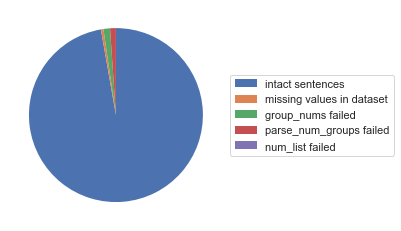

In [10]:
drop_sentences = list(drops_per_func_in_sentences.values())
drop_sentences.insert(0, n_sentences - sum(drop_sentences))
drop_sentences_labels = list(drops_per_func_in_sentences.keys())
drop_sentences_labels.insert(0, 'intact sentences')

plt.pie(drop_sentences, startangle=90, counterclock=False, wedgeprops = {'linewidth': 0})
plt.legend(drop_sentences_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f"{figures_save_path}/piecharts/dropped_sentences.png", dpi=600, bbox_inches='tight')
plt.show()
plt.close()

## Dropped Numbers

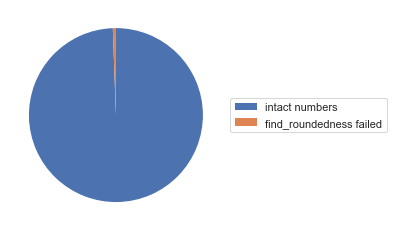

In [11]:
drop_numbers = list(drops_per_func_in_numbers.values())
drop_numbers.insert(0, n_numbers - sum(drop_numbers))
drop_numbers_labels = list(drops_per_func_in_numbers.keys())
drop_numbers_labels.insert(0, 'intact numbers')

plt.pie(drop_numbers, startangle=90, counterclock=False, wedgeprops = {'linewidth': 0})
plt.legend(drop_numbers_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f"{figures_save_path}/piecharts/dropped_numbers.png", dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Sampling Dataset to Check Validity of Preprocessing and Analysis Pipeline

In [23]:
sample_df = df.sample(n=100, random_state=random_seed, axis=0)
sample_df['num_as_str'] = sample_df['num_as_str'].apply(lambda s: "'"+s)
for full_sentence in ['sentence', 'sentence_grouped_nums', 'sentence_parsed_num_groups']:
    sample_df[full_sentence] = sample_df[full_sentence].apply(lambda s: s['form'])
sample_df.to_csv(f"{qualitative_analysis_save_path}/sample_for_limitations_section.csv")

# Plots

In [14]:
dfs = {'decimal numbers': df[df['is_float-like'] == True],
       'integers': df[df['is_float-like'] == False]
       }

binary_independent_variables = {'is_upper_house': ('house', 'lower house', 'upper house'),
                    'is_chairperson': ('speaker role', 'regular', 'chairperson'),
                    'is_mp': ('speaker type', 'not MP', 'MP'),
                    'is_female': ('gender', 'male', 'female'),
                    'is_coalition': ('party status', 'opposition', 'coalition'),
                    'is_about_money': ('counted entity', 'not money', 'money'),
                    'has_approximator': ('has an approximator', 'with', 'without')
                    }
                    # column_name, variable_name, value0 (False), value1 (True)

dependent_variables = {'num_value': 'number value',
                       # 'n_proper_digits': 'number of proper digits',
                       # 'n_zeroes': 'number of zeros',
                       # 'absolute_uncertainty': 'absolute uncertainty',
                       'relative_uncertainty': 'relative uncertainty'
                       }

max_dv_name_len = max((len(_dv) for _dv in dependent_variables))

## Scatterplots

In [15]:
plt.style.use('seaborn-deep')

for df_name, _df in dfs.items():

    for biv_key, (biv_name, biv_false_value, biv_true_value) in binary_independent_variables.items():

        data = _df.copy()
        data[biv_name] = _df[biv_key].replace({False: biv_false_value, True: biv_true_value, 'n/a': 'other'}, inplace=False)

        x_axis = 'num_value'
        y_axis = 'relative_uncertainty'

        sns.scatterplot(x=x_axis, y=y_axis, hue=biv_name, data=data, style=biv_name) #alpha=0.2,

        plt.title(f"distribution of {df_name} by {biv_name}")
        plt.xlabel('number value')
        plt.ylabel('relative uncertainty')
        plt.legend(loc='upper right')

        plt.xscale('log')
        plt.savefig(f"{figures_save_path}/scatterplots/{df_name}--{biv_name}--x-{x_axis}--y-{y_axis}.png",
                    dpi=300)
        plt.close()

## Histograms

In [17]:
# TODO: fix width of bars
#  https://stackoverflow.com/questions/38234545/multiple-histograms-with-logarithmic-x-scale
#  https://stackoverflow.com/questions/30551694/logarithmic-multi-sequenz-plot-with-equal-bar-widths
#  or do step diagram instead
#  also consider different y-axes to normalize https://stackoverflow.com/a/47750425/18420741
# TODO: AttributeError: 'Rectangle' object has no property 'labels'
# TODO: make sure max_number_value is part of diagram!

plt.style.use('seaborn-deep')

for df_name, _df in dfs.items():

    for biv_key, (biv_name, biv_false_value, biv_true_value) in binary_independent_variables.items():

        for dv, dv_name in dependent_variables.items():

            distribution_biv_true = _df[_df[biv_key] == True][dv]
            distribution_biv_false = _df[_df[biv_key] == False][dv]
            distribution_biv_other = _df[(_df[biv_key] != True) & (_df[biv_key] != False)][dv]

            if distribution_biv_other.shape[0] == 0:
                distributions = [distribution_biv_true, distribution_biv_false]
                labels = [biv_true_value, biv_false_value]
            else:
                distributions = [distribution_biv_true, distribution_biv_false, distribution_biv_other]
                labels = [biv_true_value, biv_false_value, 'other']


            for normed in (True, False):
                if normed:
                    plt.title(f"{df_name} by {biv_name} - normalized")
                    save_path = f"{figures_save_path}/histograms/{df_name}-{dv}-{biv_name}-normalized.png"
                    plt.ylabel("percentage")
                else:
                    plt.title(f"{df_name} by {biv_name}")
                    save_path = f"{figures_save_path}/histograms/{df_name}-{dv}-{biv_name}-not_normalized.png"
                    plt.ylabel("count")

                plt.xlabel(dv_name)

                if dv in {'num_value', 'absolute_uncertainty'}:
                    plt.xscale('log')
                    bins = [5**i for i in range(30)]
                elif dv == 'relative_uncertainty':
                    bins = [0.05*i for i in range(21)]
                else:
                    bins = range(15)

                if normed:
                    plt.hist(distributions, bins=bins, weights=[np.ones(len(dist)) / len(dist) for dist in distributions]) # labels=labels,
                    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
                else:
                    plt.hist(distributions, bins=bins) #, label=labels) # , histtype='step')

                plt.legend(title=biv_name, labels=labels,  loc='upper right')

                plt.savefig(
                    save_path,
                    dpi=300,
                    bbox_inches="tight")
                plt.close()

## Boxplots

In [ ]:
GAP_BETWEEN_CATEGORIES = 0.5  # How much extra space should be between different categories
BOX_PLOT_STEP = 0.7  # How much to increment x for each box plot. Boxplots have a default width of 0.5
CATEGORY_LABEL_POSITION = 0.35  # How much, relative to the height of the whole figure, should the category label be below the x-axis

FONT_SIZE_AXIS_LABEL = 20
FONT_SIZE_TITLE = 20
FONT_SIZE_X_TICK = 12

PLOT_DEFAULT_WIDTH = 2  # Approximate width (in inches) of an empty plot
BOX_PLOT_WIDTH = 1  # Approximate width (in inches) that the plot grows when a boxplot is added

# Custom adjustment of column labels. column_name_in_dataframe => new_column_name
COLUMN_LABEL_MAPPING = {
    "party status: other": "other"
}

In [ ]:
def compute_dataframe_grouping(_df) -> Tuple[List[float], List[float]]:
    box_plot_x_positions = []
    category_separator_x_positions = []  # Positions of vertical lines that visualize where the next category starts

    _prev_col_category = None
    _next_x_position = -BOX_PLOT_STEP
    for col in _df.columns:
        col_category = None

        if col == 'total':
            # Special case for 'total' column which is not listed in binary_independent_variables dict
            col_category = 'total'
        elif col in {'party status: other', 'other'}:
            col_category = _prev_col_category
        else:
            # Try to find column name in the binary_independent_variables dictionary
            # This gives us the category that this column belongs to
            for var_category, var_values in binary_independent_variables.items():
                if col in var_values:
                    col_category = var_category

        assert col_category is not None, f"Could not find category for column {col}"

        # Create a small gap between box plots if the next boxplot belongs to a different category
        if _prev_col_category is not None and col_category != _prev_col_category:
            category_separator_x_positions.append(_next_x_position + (BOX_PLOT_STEP + GAP_BETWEEN_CATEGORIES) / 2)
            _next_x_position += GAP_BETWEEN_CATEGORIES

        _next_x_position += BOX_PLOT_STEP
        _prev_col_category = col_category
        box_plot_x_positions.append(_next_x_position)

    return box_plot_x_positions, category_separator_x_positions

### Single Categories

In [ ]:
plt.style.use('seaborn-deep')

for df_name, _df in dfs.items():

    for dv, dv_name in dependent_variables.items():
        plt.title(f"distribution of {dv_name}")

        for biv_key, (biv_name, biv_false_value, biv_true_value) in binary_independent_variables.items():

            combined_df = _df[dv].to_frame(name='total') #.rename(columns={dv: 'total'})

            combined_df[biv_true_value] = _df[_df[biv_key] == True][dv]
            combined_df[biv_false_value] = _df[_df[biv_key] == False][dv]

            distribution_biv_other = _df[(_df[biv_key] != True) & (_df[biv_key] != False)][dv]
            if distribution_biv_other.shape[0] != 0:
                combined_df['other'] = distribution_biv_other

            box_plot_x_positions, category_separator_x_positions = compute_dataframe_grouping(combined_df)

            figwidth = PLOT_DEFAULT_WIDTH + len(combined_df.columns) * BOX_PLOT_WIDTH

            combined_df.plot(kind='box', rot=45, showfliers=False, positions=box_plot_x_positions, widths=0.5, figsize=(figwidth, 6))


            plt.title(f"{df_name} by {biv_name}")
            plt.ylabel(dv_name)

            # Set font sizes
            plt.gca().yaxis.label.set_fontsize(FONT_SIZE_AXIS_LABEL)
            plt.gca().title.set_fontsize(FONT_SIZE_TITLE)
            for x_tick_label in plt.gca().get_xticklabels():
                x_tick_label.set_fontsize(FONT_SIZE_X_TICK)

            # Plot separators between categories
            for category_separator_x_position in category_separator_x_positions:
                plt.axvline(category_separator_x_position, linestyle='--', color='darkgray')

            # change y_axis ticks so they don't say 1e6 at the top of the y_axis and coefficients on the ticks
            # instead have it say million if the value is in the millions
            current_y_ticks = plt.gca().get_yticks()
            if max(current_y_ticks) > 10 ** 6:
                plt.gca().set_yticklabels(['{:.0f}M'.format(x/10**6)  for x in current_y_ticks])

            plt.savefig(f"{figures_save_path}/boxplots/{df_name}-{dv}-{biv_name}.png",
                        dpi=300,
                        bbox_inches="tight")

# for saving with log y-scale activate the following lines:
#            plt.yscale('log')

#            plt.savefig(f"{figures_save_path}/boxplots/{df_name}-{dv}-{biv_name}-log_scale.png",
#                        dpi=300,
#                        bbox_inches="tight")

#            plt.show()
            plt.close()

 ### All-in-One with normal money

In [ ]:
plt.style.use('seaborn-deep')

# TODO: group by category @Tobias

for df_name, _df in dfs.items():

    for dv, dv_name in dependent_variables.items():
        combined_df = _df[dv].to_frame(name='total')

        # Select only columns listed in binary_independent_variables
        for biv_key, (biv_name, biv_false_value, biv_true_value) in binary_independent_variables.items():

            combined_df[biv_true_value] = _df[_df[biv_key] == True][dv]
            combined_df[biv_false_value] = _df[_df[biv_key] == False][dv]

            distribution_biv_other = _df[(_df[biv_key] != True) & (_df[biv_key] != False)][dv]
            if distribution_biv_other.shape[0] != 0:
                combined_df[f"{biv_name}: other"] = distribution_biv_other

        box_plot_x_positions, category_separator_x_positions = compute_dataframe_grouping(combined_df)
        column_names = combined_df.columns
        column_names = [COLUMN_LABEL_MAPPING[col_name]
                        if col_name in COLUMN_LABEL_MAPPING
                        else col_name
                        for col_name
                        in column_names]
        combined_df.columns = column_names

        combined_df.plot(kind='box', rot=45, figsize=(20, 4.8), showfliers=False, positions=box_plot_x_positions)

        # Plot separators between categories
        for category_separator_x_position in category_separator_x_positions:
            plt.axvline(category_separator_x_position, linestyle='--', color='darkgray')

        plt.title(f"{df_name}")
        plt.ylabel(dv_name)

        # Set font sizes
        plt.gca().yaxis.label.set_fontsize(FONT_SIZE_AXIS_LABEL)
        plt.gca().title.set_fontsize(FONT_SIZE_TITLE)
        for x_tick_label in plt.gca().get_xticklabels():
            x_tick_label.set_fontsize(FONT_SIZE_X_TICK)


        # change y_axis ticks so they don't say 1e6 at the top of the y_axis and coefficients on the ticks
        # instead have it say million if the value is in the millions
        current_y_ticks = plt.gca().get_yticks()
        if max(current_y_ticks) > 10 ** 6:
            plt.gca().set_yticklabels(['{:.0f}M'.format(x/10**6)  for x in current_y_ticks])

        # Add category labels centered below the respective column names
        for i_category, (category, col_names) in enumerate(binary_independent_variables.items()):
            if i_category < len(binary_independent_variables.keys()) - 1:
                # Position of category label is computed by taking the middle positions of the
                # left and right category separator line
                category_label_x_position = (category_separator_x_positions[i_category] + category_separator_x_positions[i_category + 1]) / 2
            else:
                # Special case for the last category label since we don't have a separator line to the right of that
                category_label_x_position = category_separator_x_positions[i_category] + GAP_BETWEEN_CATEGORIES / 2 + (len(col_names) - 1) * BOX_PLOT_STEP / 2

            category_label_y_position = -CATEGORY_LABEL_POSITION* current_y_ticks[-1]
            category_label = col_names[0]
            plt.text(category_label_x_position, category_label_y_position, col_names[0], horizontalalignment='center', fontsize=15)


        plt.savefig(f"{figures_save_path}/boxplots/{df_name}-{dv}-all_in_one.png",
                    dpi=300,
                    bbox_inches="tight")

# for saving with log y-scale activate the following lines:
#        plt.yscale('log')

#        plt.savefig(f"{figures_save_path}/boxplots/{df_name}-{dv}-all_in_one-log_scale.png",
#                    dpi=300,
#                    bbox_inches="tight")


#        plt.show()
        plt.close()


# Qualitative Analysis: Generate .csv files

In [ ]:
columns_to_investigate = ['sent_id', 'Speaker_name', 'is_coalition', 'is_mp', 'is_female', 'is_upper_house', 'is_chairperson', 'sentence','num_value', 'is_float-like', 'relative_uncertainty', 'is_about_money', 'has_approximator', 'approximators']

# high number values
df[columns_to_investigate].sort_values(by='num_value', ascending=False, inplace=False).iloc[:100].to_csv(f"{qualitative_analysis_save_path}/high_number_values.csv")

# negative number values
df[columns_to_investigate][df['num_value'] < 0].to_csv(f"{qualitative_analysis_save_path}/negative_number_values.csv")

# low relative uncertainty
df[columns_to_investigate].sort_values(by='relative_uncertainty', ascending=True, inplace=False).iloc[:100].to_csv(f"{qualitative_analysis_save_path}/low_relative_uncertainty.csv")

# high relative uncertainty
df[columns_to_investigate].sort_values(by='relative_uncertainty', ascending=False, inplace=False).iloc[:100].to_csv(f"{qualitative_analysis_save_path}/low_relative_uncertainty.csv")

## Random Shit

In [ ]:
df[df['is_float-like']][columns_to_investigate].sort_values(by='num_value', ascending=False, inplace=False).iloc[:100].to_csv(f"{qualitative_analysis_save_path}/float-likes--high_number_values.csv")

In [25]:
df[df['is_about_money']].shape

(135470, 25)